In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../DanceRevolution/')
sys.path.append('../src')
sys.path.append('../DanceRevolution/v2')
from v2.utils.functional import load_test_data, load_data
from v2.keypoint2img import read_keypoints, define_edge_lists, extract_valid_keypoints
from skeleton_sequence import SkeletonSequence
from skeleton_structure import DanceRevolutionStructure
import numpy as np
from moviepy.editor import ipython_display
from pathlib import Path
import json
import matplotlib.pyplot as plt

In [2]:
def visualize_json(json_path, width=1280, height=720):  # taken from inference.py in DanceRevolution, just for convenience
    return read_keypoints(json_path, (width, height), remove_face_labels=False, basic_point_only=False)

In [3]:
def parse_sequence(s, scale_input=False, w=None, h=None):
    if scale_input:
        assert w is not None and h is not None
        
    x = np.array(s)
        
    x = x.reshape(-1, 25, 2)
    x = np.expand_dims(x.transpose((2, 0, 1)), 3)
    
    if scale_input:
        x[0] = (x[0] + 1) * 0.5 * w
        x[1] = (x[1] + 1) * 0.5 * h

    return x

# Data comparison

I generated the data from the raw audio/json files using their preprocessing script. Now I compare the sequences. Note that because train/test splits are random we need to look at the filenames to match the sequences

In [4]:
original_test_data_path = '/home/dingxi/DanceRevolution/data/test_1min'
# my_test_data_path = '/home/davide/data/datasets/dance_revolution/my_data/test_1min'

In [5]:
_, origin_test_dance, original_test_fnames = load_test_data(original_test_data_path)
# _, my_test_dance, my_test_fnames = load_test_data(my_test_data_path)

['ballet_1min_0003_00_0.json', 'ballet_1min_0003_00_1.json', 'ballet_1min_0012_01_0.json', 'ballet_1min_0012_01_1.json', 'ballet_1min_0013_01_0.json', 'ballet_1min_0013_01_1.json', 'ballet_1min_0025_01_0.json', 'ballet_1min_0025_01_1.json', 'ballet_1min_0028_00_0.json', 'ballet_1min_0028_00_1.json', 'ballet_1min_0029_00_0.json', 'ballet_1min_0029_00_1.json', 'ballet_1min_0031_01_0.json', 'ballet_1min_0031_01_1.json', 'ballet_1min_0037_01_0.json', 'ballet_1min_0037_01_1.json', 'ballet_1min_0040_00_0.json', 'ballet_1min_0040_00_1.json', 'ballet_1min_0044_01_0.json', 'ballet_1min_0044_01_1.json', 'hiphop_1min_0012_00_0.json', 'hiphop_1min_0012_00_1.json', 'hiphop_1min_0022_01_0.json', 'hiphop_1min_0022_01_1.json', 'hiphop_1min_0032_01_0.json', 'hiphop_1min_0032_01_1.json', 'hiphop_1min_0036_02_0.json', 'hiphop_1min_0036_02_1.json', 'hiphop_1min_0043_00_0.json', 'hiphop_1min_0043_00_1.json', 'hiphop_1min_0044_00_0.json', 'hiphop_1min_0044_00_1.json', 'hiphop_1min_0044_03_0.json', 'hiphop_1

In [6]:
origin_test_dance[0].shape

(900, 50)

In [8]:
check = []

for seq, name in zip(my_test_dance, my_test_fnames):
    if name not in original_test_fnames:
        continue
        
    other_idx = original_test_fnames.index(name)
    other_seq = origin_test_dance[other_idx]
    
    check.append(np.array_equal(seq, other_seq))
    
print('Check', all(check))

NameError: name 'my_test_dance' is not defined

In [7]:
original_train_data_path = '/home/dingxi/DanceRevolution/data/train_1min'
# my_train_data_path = '/home/davide/data/datasets/dance_revolution/my_data/train_1min'

In [11]:
_, origin_train_dance, original_train_frames = load_data(original_train_data_path, interval=900)
#                                                          , return_fnames=True)
# _, my_train_dance, my_train_fnames = load_data(my_train_data_path, interval=900, return_fnames=True)

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
check = []

for seq, name in zip(my_train_dance, my_train_fnames):
    if name not in original_train_frames:
        continue
        
    other_idx = original_train_frames.index(name)
    other_seq = origin_train_dance[other_idx]
    
    check.append(np.array_equal(seq, other_seq))

print('Check', all(check))

Conclusion: the data they released is pre-processed. Let's stick to their data so we use the same splits

# Problems

- Was not able to visualise data with their own code (fixed, see below)
- Visualising their data with my code produces very jittery sequences. **Thoughts on this**: my video looks more jittery also because I do not set a min/max frame. Doing that would perceptually compress the movements, so I need to do that too

In [17]:
seq_i = 0
frame_i = 0
w = 1280
h = 720

s = parse_sequence(origin_test_dance[seq_i], scale_input=True, w=w, h=h)
pose_d = DanceRevolutionStructure()
sequence = SkeletonSequence(s, dataset=pose_d, is_2d=True, cache=False)
print('Sequence name', original_test_fnames[seq_i])

# by setting the ax limits, because we rescaled the inputs too we will replicate the same look as in the original videos
ipython_display(sequence.animate_skeleton(ax_limits=(0, w, 0, h)), fps=10, maxduration=1000)  

t:   1%|          | 5/900 [00:00<00:23, 37.97it/s, now=None]

Sequence name ballet_1min_0003_00_0.json
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


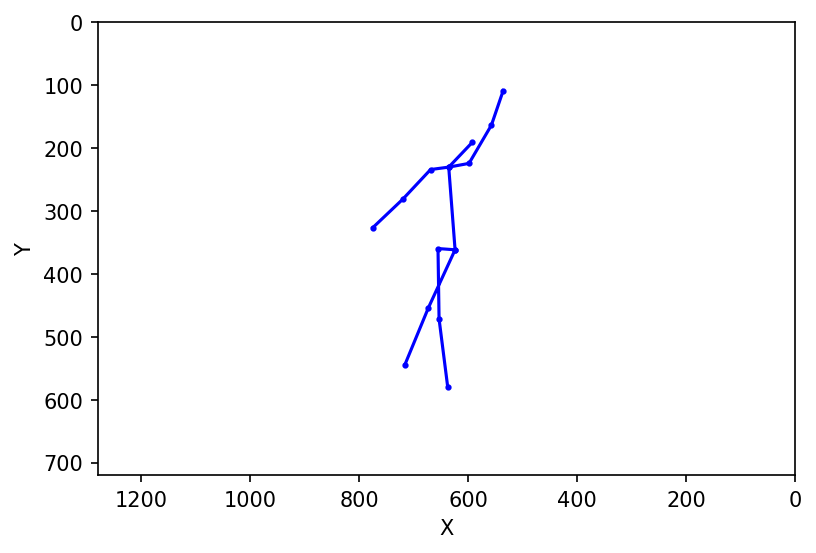

In [13]:
sequence.plot(0, ax_limits=(w, 0, h, 0))

# Notes

- It seems that when we load the data with their functions we do not threshold the pose confidence, which they do when they load json files one by one when plotting the frames. This is probably why we see jittery results here
- The generated poses contain a confidence score too, so their output in the json file is 75-dimensional, 25 nodes times (x, y, confidence), although confidence is hard-coded to 0.8 (see below)
- The (x, y) range of the generated poses is very different from the original range. This is also why the interpolation functions do not work for the original data, they are meant to work on very different numbers. **Update** this is because when they save the json files their rescale x and y to be in the frame coordinates (see below)

In [4]:
# jp = '/home/davide/data/scratch/dance_revolution_test/pop_1min_0049_04_1.json/frame000001_keypoints.json'
jp = '/home/dingxi/DanceRevolution/data/train_1min/'

with open(jp) as f:
    d = json.load(f)

In [5]:
d.keys()

dict_keys(['id', 'music_array', 'dance_array'])

In [18]:
len(d['people'][0]['pose_keypoints_2d'])

KeyError: 'people'

In [ ]:
d['people'][0]['pose_keypoints_2d']

In [ ]:
plt.imshow(visualize_json(jp))

## Conclusions

- Their data visualisation is not meant to be used with the raw data, but only with the generated results 
- When they load they data for training/testing they do not seem to threshold poses based on the confidence scores, which is probably why we see funny poses when we plot everything

# Rescaling input

When they write the json file they do

```python
x = (keypoint[0] + 1) * 0.5 * args.width
y = (keypoint[1] + 1) * 0.5 * args.height
score = 0.8
```

- Where width and height are 1280 and 720 (the picture frame). This is why the output is in a different range. Try to rescale things in the same way and then plot the original sequences using the same functions, without thresholding the confidence score. 
- Compare then to my plot with thresholding

# Understanding the processed data shape

In [1]:
import os
import json
import random
import numpy as np
from tqdm.auto import tqdm

In [5]:
# check frames in the raw dataset (preprocessed with raw json without interpolation)
# if any frame is missing
input_dir = '/home/dingxi/DanceRevolution/data/all_1min_notwins'
missing_joints = 0
missing_frames = 0
file_list = os.listdir(input_dir)
for file in tqdm(file_list):
    file_path = os.path.join(input_dir, file)

    # read raw data
    with open(file_path, 'r') as f:
        raw = json.loads(f.read())
    dance = np.array(raw['dance_array'])[:, :50]
    dance = dance.reshape(-1, 25, 2)
    for i in range(len(dance)):
        flag = 1
        for j in range(len(dance[0])):
            if dance[i][j][0] > -1 or dance[i][j][1] > -1:
                flag = 0
            elif dance[i][j][0] == -1 and dance[i][j][1] == -1:
                missing_joints += 1
        missing_frames += flag
        
print(missing_joints)
print(missing_frames)

  0%|          | 0/394 [00:00<?, ?it/s]

0
26


In [6]:
with open('/home/dingxi/DanceRevolution/data/all_1min/pop_1min_0054_00_0.json') as f:
    dd = json.load(f)

In [7]:
a = np.array(dd['dance_array'])

In [8]:
a.shape

(792, 274)

The above tells us that each sequence is represented with a 2D array where the first dimension is time and the second is the concatenation of `body, face, left hand, right hand` (x, y) coordinates. Unfortunately they removed the confidence score from all these keypoints (code from `load_dance_data` in `prepro.py:

```python
keypoint_dict = keypoint_dicts[0]
pose_points = np.array(keypoint_dict['pose_keypoints_2d']).reshape(25, 3)[:, :-1].reshape(-1)
face_points = np.array(keypoint_dict["face_keypoints_2d"]).reshape(70, 3)[:, :-1].reshape(-1) if not remove_face_keypoints else []
hand_points_l = np.array(keypoint_dict["hand_left_keypoints_2d"]).reshape(21, 3)[:, :-1].reshape(-1) if not remove_hand_keypoints else []
hand_points_r = np.array(keypoint_dict["hand_right_keypoints_2d"]).reshape(21, 3)[:, :-1].reshape(-1) if not remove_hand_keypoints else []
key_points = np.concatenate([pose_points, face_points, hand_points_l, hand_points_r], 0)
```

Notice the `-1` in `reshape(25, 3)[:, :-1]`, which excludes the confidence score. Summing up the dimensions from above we get `(25x2) + (70x2) + (21x2) + (21x2) = 274`, the second dimension from each single array we get from a processed json file, which also confirms that the processed json file contain keypoints for pose, face and hands.

# The final word

The problem was in the centre/spinal node. Once I changed that from 8 (the right node according to figures I found on the internet) to 9 it just works fine. Let's compare two videos below.

In [22]:
from moviepy.editor import VideoFileClip, clips_array

original_clip = VideoFileClip('/home/davide/data/datasets/dance_revolution/dance_revolution_videos/ballet_pose-t=0/0003_00.mp4')
my_clip = VideoFileClip('/home/davide/Desktop/ballet_1min_0003_00_0_30fps.mp4')
stacked_clip = clips_array([[original_clip, my_clip]])
stacked_clip.write_videofile('/home/davide/Desktop/ballet_comparison.mp4')

t:   0%|          | 4/1801 [00:00<01:01, 29.32it/s, now=None]

Moviepy - Building video /home/davide/Desktop/ballet_comparison.mp4.
Moviepy - Writing video /home/davide/Desktop/ballet_comparison.mp4



Moviepy - Done !
Moviepy - video ready /home/davide/Desktop/ballet_comparison.mp4
